In [24]:
import os
import pandas as pd
import numpy as np
import librosa
import networkx as nx
import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv, global_mean_pool
from torch.nn import Linear, ReLU, Dropout, CrossEntropyLoss
from torch.optim import Adam


In [2]:
RAVDESS = "/kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/"
CREMA = "/kaggle/input/cremad/AudioWAV/"
TESS = "/kaggle/input/toronto-emotional-speech-set-tess/tess toronto emotional speech set data/TESS Toronto emotional speech set data/"
SAVEE = "/kaggle/input/surrey-audiovisual-expressed-emotion-savee/ALL/"

**1. Ravdess Dataframe**

There are 1440 audio files, for example, 03-01-**06**-01-02-01-12.wav.

In [3]:
ravdess_dir_lis = os.listdir(RAVDESS)
path_list = []
gender_list = []
emotion_list = []

emotion_dic = {
    '03' : 'happy',
    '01' : 'neutral',
    '04' : 'sad',
    '05' : 'angry',
    '06' : 'fear',
    '07' : 'disgust',
}

for directory in ravdess_dir_lis:
    actor_files = os.listdir(os.path.join(RAVDESS, directory))
    for audio_file in actor_files: 
        part = audio_file.split('.')[0]
        key = part.split('-')[2]
        if key in emotion_dic:
            gender_code = int(part.split('-')[6])
            path_list.append(f"{RAVDESS}{directory}/{audio_file}")
            gender_list.append('female' if gender_code & 1 == 0 else 'male')
            emotion_list.append(emotion_dic[key])
            
ravdess_df = pd.concat([
    pd.DataFrame(path_list, columns=['path']),
    pd.DataFrame(gender_list, columns=['sex']),
    pd.DataFrame(emotion_list, columns=['emotion'])
], axis=1)

ravdess_df.head()

,path,sex,emotion
0,/kaggle/input/ravdess-emotional-speech-audio/a...,female,neutral
1,/kaggle/input/ravdess-emotional-speech-audio/a...,female,disgust
2,/kaggle/input/ravdess-emotional-speech-audio/a...,female,disgust
3,/kaggle/input/ravdess-emotional-speech-audio/a...,female,neutral
4,/kaggle/input/ravdess-emotional-speech-audio/a...,female,fear


**2. Crema-D Dataframe**

There are 7,442 audio files, for example, 1001_DFA_**ANG**_XX.wav.

In [4]:
crema_dir_list = os.listdir(CREMA)
path_list = []
gender_list = []
emotion_list = []

emotion_dic = {
    'HAP' : 'happy',
    'NEU' : 'neutral',
    'SAD' : 'sad',
    'ANG' : 'angry',
    'FEA' : 'fear',
    'DIS' : 'disgust',
}

female_id_list = [
    '1002', '1003', '1004', '1006', '1007', '1008', '1009', '1010', '1012', '1013', '1018', 
    '1020', '1021', '1024', '1025', '1028', '1029', '1030', '1037', '1043', '1046', '1047', 
    '1049', '1052', '1053', '1054', '1055', '1056', '1058', '1060', '1061', '1063', '1072', 
    '1073', '1074', '1075', '1076', '1078', '1079', '1082', '1084', '1089', '1091',
]

for audio_file in crema_dir_list:
    part = audio_file.split('_')
    key = part[2]
    if key in emotion_dic and part[3] == 'HI.wav':
        path_list.append(f"{CREMA}{audio_file}")
        gender_list.append('female' if part[0] in female_id_list else 'male')
        emotion_list.append(emotion_dic[key])

crema_df = pd.concat([
    pd.DataFrame(path_list, columns=['path']),
    pd.DataFrame(gender_list, columns=['sex']),
    pd.DataFrame(emotion_list, columns=['emotion'])
], axis=1)

crema_df.head()

,path,sex,emotion
0,/kaggle/input/cremad/AudioWAV/1032_IEO_HAP_HI.wav,male,happy
1,/kaggle/input/cremad/AudioWAV/1076_IEO_FEA_HI.wav,female,fear
2,/kaggle/input/cremad/AudioWAV/1056_IEO_ANG_HI.wav,female,angry
3,/kaggle/input/cremad/AudioWAV/1038_IEO_SAD_HI.wav,male,sad
4,/kaggle/input/cremad/AudioWAV/1043_IEO_DIS_HI.wav,female,disgust


**3. Tess Dataframe**

There are 2,800 audio files, for example, OAF_base_**fear**.wav.

In [5]:
tess_dir_list = os.listdir(TESS)
path_list = []
gender_list = []
emotion_list = [] 

emotion_dic = {
    'happy'   : 'happy',
    'neutral' : 'neutral',
    'sad'     : 'sad',
    'Sad'     : 'sad',
    'angry'   : 'angry',
    'fear'    : 'fear',
    'disgust'  : 'disgust',
}

for directory in tess_dir_list:
    audio_files = os.listdir(os.path.join(TESS, directory))
    for audio_file in audio_files:
        part = audio_file.split('.')[0]
        key = part.split('_')[2]
        if key in emotion_dic:
            path_list.append(f"{TESS}{directory}/{audio_file}") 
            gender_list.append('female') # female only dataset
            emotion_list.append(emotion_dic[key])
            
tess_df = pd.concat([
    pd.DataFrame(path_list, columns=['path']),
    pd.DataFrame(gender_list, columns=['sex']),
    pd.DataFrame(emotion_list, columns=['emotion'])
], axis=1)

tess_df.head()

,path,sex,emotion
0,/kaggle/input/toronto-emotional-speech-set-tes...,female,fear
1,/kaggle/input/toronto-emotional-speech-set-tes...,female,fear
2,/kaggle/input/toronto-emotional-speech-set-tes...,female,fear
3,/kaggle/input/toronto-emotional-speech-set-tes...,female,fear
4,/kaggle/input/toronto-emotional-speech-set-tes...,female,fear


**4. Savee Dataframe**

There are 480 audio files, for example, DC_**a**02.wav.

In [6]:
savee_dir_list = os.listdir(SAVEE)
path_list = []
gender_list = []
emotion_list = []

emotion_dic = {
    'h'  : 'happy',
    'n'  : 'neutral',
    'sa' : 'sad',
    'a'  : 'angry',
    'f'  : 'fear',
    'd'  : 'disgust'
}

for audio_file in savee_dir_list:
    part = audio_file.split('_')[1]
    key = part[:-6]
    if key in emotion_dic:
        path_list.append(f"{SAVEE}{audio_file}")
        gender_list.append('male') # male only dataset
        emotion_list.append(emotion_dic[key])
        
savee_df = pd.concat([
    pd.DataFrame(path_list, columns=['path']),
    pd.DataFrame(gender_list, columns=['sex']),
    pd.DataFrame(emotion_list, columns=['emotion'])
], axis=1)

savee_df.head()

,path,sex,emotion
0,/kaggle/input/surrey-audiovisual-expressed-emo...,male,happy
1,/kaggle/input/surrey-audiovisual-expressed-emo...,male,fear
2,/kaggle/input/surrey-audiovisual-expressed-emo...,male,happy
3,/kaggle/input/surrey-audiovisual-expressed-emo...,male,disgust
4,/kaggle/input/surrey-audiovisual-expressed-emo...,male,angry


In [7]:
df = pd.concat([
    ravdess_df, 
    crema_df, 
    tess_df, 
    savee_df
], axis=0)
df.head()

,path,sex,emotion
0,/kaggle/input/ravdess-emotional-speech-audio/a...,female,neutral
1,/kaggle/input/ravdess-emotional-speech-audio/a...,female,disgust
2,/kaggle/input/ravdess-emotional-speech-audio/a...,female,disgust
3,/kaggle/input/ravdess-emotional-speech-audio/a...,female,neutral
4,/kaggle/input/ravdess-emotional-speech-audio/a...,female,fear


# 2. Quick EDA

We check for imbalances like male to female ratio. 

In [8]:
import librosa
import matplotlib.pyplot as plt

plt.style.use('ggplot')


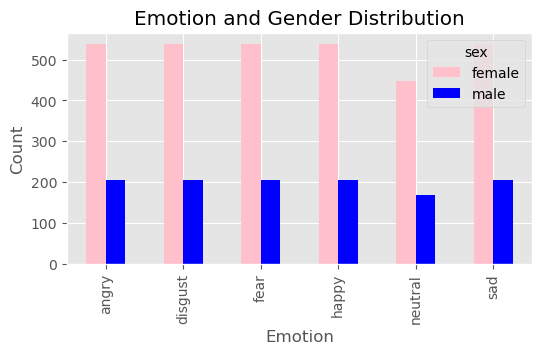

In [9]:
def plot_distribution(df): 
    countTable = df.groupby(['emotion', 'sex']).count()
    pivotTable = countTable.pivot_table(index='emotion', columns='sex', values='path')

    pivotTable.plot(kind='bar', figsize=(6, 3), color=['pink', 'blue'])
    plt.title('Emotion and Gender Distribution')
    plt.xlabel('Emotion')
    plt.ylabel('Count')
    plt.show()
    
plot_distribution(df)

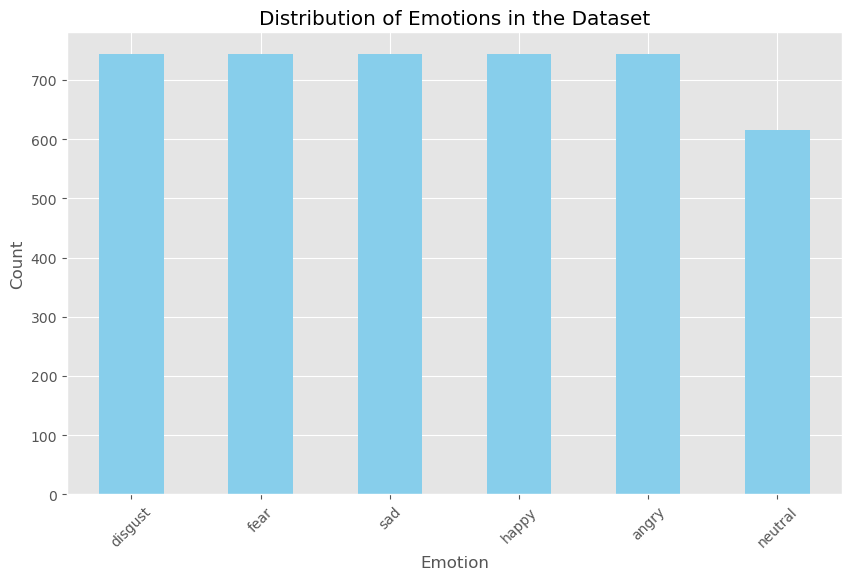

In [10]:
plt.figure(figsize=(10, 6))
df['emotion'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Distribution of Emotions in the Dataset')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

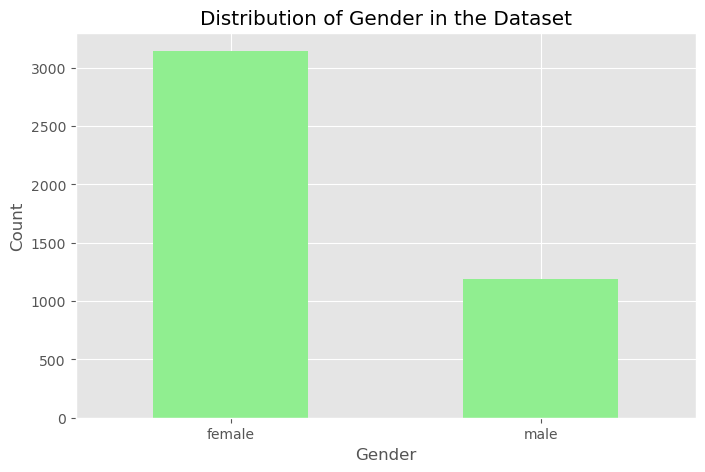

In [11]:
plt.figure(figsize=(8, 5))
df['sex'].value_counts().plot(kind='bar', color='lightgreen')
plt.title('Distribution of Gender in the Dataset')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

In [12]:
if 'dataset' in df.columns:
    plt.figure(figsize=(10, 6))
    df['dataset'].value_counts().plot(kind='bar', color='salmon')
    plt.title('Number of Samples per Dataset')
    plt.xlabel('Dataset')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.show()

In [13]:
df.head()

,path,sex,emotion
0,/kaggle/input/ravdess-emotional-speech-audio/a...,female,neutral
1,/kaggle/input/ravdess-emotional-speech-audio/a...,female,disgust
2,/kaggle/input/ravdess-emotional-speech-audio/a...,female,disgust
3,/kaggle/input/ravdess-emotional-speech-audio/a...,female,neutral
4,/kaggle/input/ravdess-emotional-speech-audio/a...,female,fear


In [14]:
df.drop('sex', axis=1, inplace=True)
df.head()

,path,emotion
0,/kaggle/input/ravdess-emotional-speech-audio/a...,neutral
1,/kaggle/input/ravdess-emotional-speech-audio/a...,disgust
2,/kaggle/input/ravdess-emotional-speech-audio/a...,disgust
3,/kaggle/input/ravdess-emotional-speech-audio/a...,neutral
4,/kaggle/input/ravdess-emotional-speech-audio/a...,fear


In [15]:
df.rename(columns={'path': 'file_path'}, inplace=True)


In [16]:
pip install resampy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 32.9 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [17]:
def extract_features(file_path):
    audio, sample_rate = librosa.load(file_path, res_type='kaiser_fast')
    mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    return mfccs.T  # Transpose for graph representation

df['features'] = df['file_path'].apply(extract_features)

# Drop samples with failed feature extraction
df = df.dropna(subset=['features'])


In [21]:
pip install torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 661.6/661.6 kB 13.5 MB/s eta 0:00:00a 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for torch-geometric: filename=torch_geometric-2.3.1-py3-none-any.whl size=910453 sha256=254e8094ebecbaa7ec7936f73eeabf4c8b4757b5e989776dcd35ed29cbd5e142
  Stored in directory: /root/.cache/pip/wheels/e6/38/f7/02dfdd521e2f6c7021083b41a7328fd290d2f4b4759ef14428
Successfully built torch-geometric
Note: you may need to restart the kernel to use updated packages.


In [22]:
import torch
from torch_geometric.data import Data


def create_graph(features):
    num_nodes = features.shape[0]
    edge_index = torch.tensor(
        [[i, i + 1] for i in range(num_nodes - 1)], dtype=torch.long
    ).t().contiguous()  # Temporal edges

    x = torch.tensor(features, dtype=torch.float)
    return Data(x=x, edge_index=edge_index)

df['graph'] = df['features'].apply(create_graph)


In [25]:
label_encoder = LabelEncoder()
df['emotion_encoded'] = label_encoder.fit_transform(df['emotion'])

In [27]:
from torch_geometric.data import DataLoader

# Update each Data object with the corresponding emotion_encoded value
df['graph'] = df.apply(lambda row: row['graph'].clone(), axis=1)  # Clone the graph
for i, row in df.iterrows():
    row['graph'].y = torch.tensor([row['emotion_encoded']], dtype=torch.float)

# Convert the updated graphs into a list
data_list = df['graph'].tolist()

# Split the data into train, validation, and test sets
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(data_list, test_size=0.3, random_state=42)
val_data, test_data = train_test_split(test_data, test_size=0.5, random_state=42)

# Create data loaders
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)


/opt/conda/lib/python3.7/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [28]:
import torch.nn.functional as F

class GNN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GNN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.fc1 = Linear(hidden_dim, hidden_dim)
        self.fc2 = Linear(hidden_dim, output_dim)
        self.dropout = Dropout(0.5)

    def forward(self, x, edge_index, batch):
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = global_mean_pool(x, batch)  # Pooling layer
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)


In [35]:
import torch
from torch.nn import CrossEntropyLoss
from torch.optim import Adam

# Ensure device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define model, optimizer, and criterion
model = GNN(input_dim=40, hidden_dim=128, output_dim=len(label_encoder.classes_)).to(device)
optimizer = Adam(model.parameters(), lr=0.001)
criterion = CrossEntropyLoss()

# Training function
def train(loader):
    model.train()
    loss_all = 0
    for data in loader:
        data = data.to(device)
        
        # Ensure target `data.y` is of type long
        data.y = data.y.long()
        
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.batch)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        loss_all += loss.item()
    return loss_all / len(loader)

# Evaluation function
def evaluate(loader):
    model.eval()
    correct = 0
    for data in loader:
        data = data.to(device)
        
        # Ensure target `data.y` is of type long
        data.y = data.y.long()
        
        out = model(data.x, data.edge_index, data.batch)
        pred = out.argmax(dim=1)
        correct += (pred == data.y).sum().item()
    return correct / len(loader.dataset)

# Training loop
for epoch in range(500):
    train_loss = train(train_loader)
    val_acc = evaluate(val_loader)
    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Validation Accuracy: {val_acc:.4f}")


Epoch 1, Train Loss: 2.1378, Validation Accuracy: 0.5138
Epoch 2, Train Loss: 1.1100, Validation Accuracy: 0.6723
Epoch 3, Train Loss: 0.9138, Validation Accuracy: 0.7246
Epoch 4, Train Loss: 0.7874, Validation Accuracy: 0.7154
Epoch 5, Train Loss: 0.7297, Validation Accuracy: 0.7062
Epoch 6, Train Loss: 0.6863, Validation Accuracy: 0.7308
Epoch 7, Train Loss: 0.6459, Validation Accuracy: 0.7292
Epoch 8, Train Loss: 0.6239, Validation Accuracy: 0.7308
Epoch 9, Train Loss: 0.6056, Validation Accuracy: 0.7492
Epoch 10, Train Loss: 0.5832, Validation Accuracy: 0.7585
Epoch 11, Train Loss: 0.5528, Validation Accuracy: 0.7738
Epoch 12, Train Loss: 0.5425, Validation Accuracy: 0.7769
Epoch 13, Train Loss: 0.5364, Validation Accuracy: 0.7631
Epoch 14, Train Loss: 0.5133, Validation Accuracy: 0.7369
Epoch 15, Train Loss: 0.5160, Validation Accuracy: 0.7785
Epoch 16, Train Loss: 0.5077, Validation Accuracy: 0.7646
Epoch 17, Train Loss: 0.4768, Validation Accuracy: 0.7615
Epoch 18, Train Loss: 0

In [36]:
test_acc = evaluate(test_loader)
print(f"Test Accuracy: {test_acc:.4f}")

Test Accuracy: 0.8662
